# Задание 3. Оптимизация портфеля и построение эффективной границы
> выполнил Литвинов А. А., гр. МФИН211

## 1. Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data
from __future__ import division
import matplotlib.pyplot as plt # графическая библиотека
%matplotlib inline 
from os import listdir
from os.path import isfile,join # функции, необходимые для работы с файлами и директориями
import scipy.optimize as sco # оптимизация
import scipy.interpolate as sci # интерполяция (подбор функций)
from functools import reduce

## 2. Загрузка данных и их преобразование в необходимый формат

In [2]:
path = './ap_data/'


In [3]:
Tickers = ['AMZN', 'XOM', 'V', 'JPM']  # выбранные для анализа активы


In [4]:
sample_tickers = list(Tickers)
# выбор тикеров для загрузки с сервера Yahoo finance

df = data.DataReader(sample_tickers,
                     start='2014-02-18',
                     end='2021-12-31',
                     data_source='yahoo')['Close']
# загрузка дневных котировок

In [5]:
port_log = df.apply(lambda x: np.log(x) - np.log(x).shift(1)).iloc[1:]


In [6]:
port_log.head()

Symbols,AMZN,XOM,V,JPM
Date,,,,
2014-02-19,-0.017889,-0.001276,-0.009690,-0.021254
2014-02-20,0.006942,0.015001,-0.001878,0.005573
2014-02-21,-0.008729,-0.003571,-0.000448,0.000521
2014-02-24,0.014373,0.014728,0.012591,0.007264
2014-02-25,0.018420,-0.001349,0.004059,-0.017383


In [7]:
port_log.shape

(1983, 4)

## 3. Полезные функции

In [8]:
# доходность портфеля
def port_mean(weights, means, n_days=250):
    weights = np.array(weights)
    return (np.sum(means * weights) * n_days)


# дисперсия портфеля
def port_variance(weights, cov, n_days=250):
    weights = np.array(weights)
    return (np.dot(weights.T, np.dot(cov * n_days, weights)))


# волатильность портфеля
def port_vol(weights, cov, n_days=250):
    weights = np.array(weights)
    return (np.sqrt(np.dot(weights.T, np.dot(cov * n_days, weights))))


# Sharpe ratio портфеля
def Sharpe_ratio(weights, cov, means, r_f, n_days=250):
    weights = np.array(weights)
    mean = np.sum(means * weights) * n_days
    vol = np.sqrt(np.dot(weights.T, np.dot(cov * n_days, weights)))
    return -((mean - r_f) / vol)


# генерация портфелей со случайными весами
def sim_func(N_sim, n_means, cov, n_days=250):
    lrets = []
    lvols = []
    n_assets = len(means)
    for i in range(N_sim):
        weights = np.random.random(n_assets)
        weights /= np.sum(weights)
        lrets.append(port_mean(weights, means, n_days))
        lvols.append(port_vol(weights, cov, n_days))
    return (np.array(lrets), np.array(lvols))


# специальная функция для интерполяции сплайнами
def f(x, tck):
    return sci.splev(x, tck, der=0)


# специальная функция для интерполяции сплайнами (первая производная)
def df(x, tck):
    return sci.splev(x, tck, der=1)


# подбор параметров CML
def equations(p, r_f, tck):
    eq1 = r_f - p[0]
    eq2 = r_f + p[1] * p[2] - f(p[2], tck)
    eq3 = p[1] - df(p[2], tck)
    return eq1, eq2, eq3


## 4. Моделирование множества портфелей

In [9]:
# Начальные параметры
r_f = .02  # безрисковая ставка
N_sim = 2500  # количество сгенерированных портфелей со случайными весами
n_assets = port_log.shape[1]  # количество активов
n_days = 250  # количество торговых дней в году


In [11]:
# средние значения доходностей для каждого актива
means = np.mean(port_log, axis=0)
means * n_days


Symbols
AMZN    0.282870
XOM    -0.054218
V       0.169447
JPM     0.125561
dtype: float64

In [12]:
# портфель со случайными весами
w = np.random.random(n_assets)
w /= np.sum(w)
w

array([0.226643  , 0.35677947, 0.3225452 , 0.09403233])

In [13]:
# ковариационная матрица портфеля
cov = np.cov(port_log, rowvar=False)
cov

array([[3.58029672e-04, 7.30733703e-05, 1.41805462e-04, 9.07122476e-05],
       [7.30733703e-05, 2.91221028e-04, 1.33857759e-04, 1.89101991e-04],
       [1.41805462e-04, 1.33857759e-04, 2.44496188e-04, 1.62469473e-04],
       [9.07122476e-05, 1.89101991e-04, 1.62469473e-04, 2.96545147e-04]])

In [14]:
# кореляционная матрица портфеля
np.corrcoef(port_log, rowvar=False)

array([[1.        , 0.22630193, 0.47928894, 0.27839473],
       [0.22630193, 1.        , 0.5016446 , 0.64348633],
       [0.47928894, 0.5016446 , 1.        , 0.60337917],
       [0.27839473, 0.64348633, 0.60337917, 1.        ]])

In [15]:
# реализация функции генерации портфелей
# результат - массив доходностей и волатильностей
rets, vols = sim_func(N_sim, means, cov)


In [16]:
rets

array([0.14137103, 0.14158418, 0.05929089, ..., 0.10677129, 0.12154408,
       0.12884979])

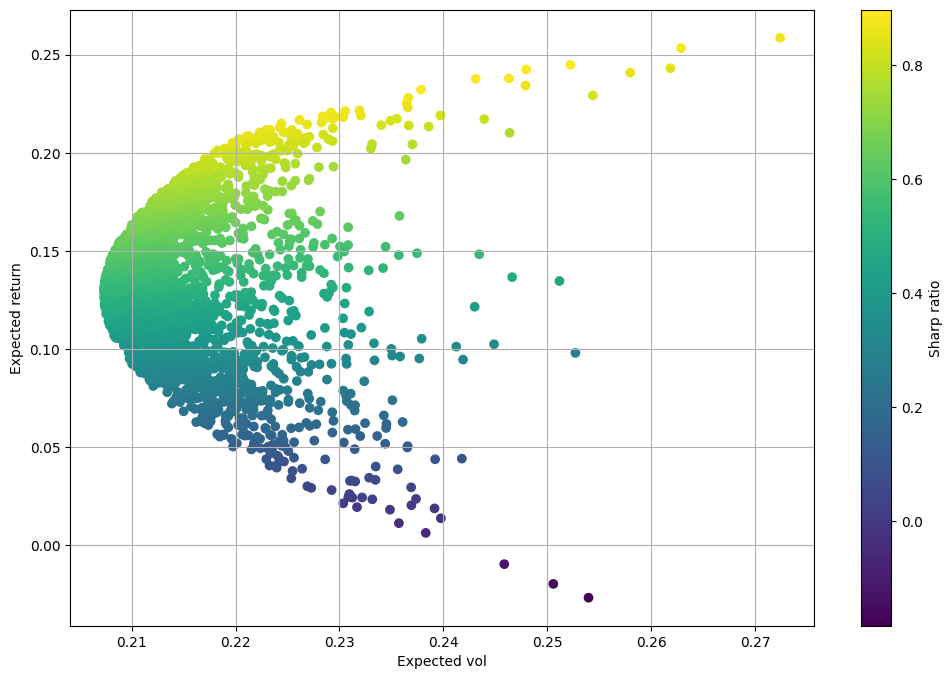

In [19]:
_ = plt.figure(figsize=(12, 8))
_ = plt.scatter(vols, rets, c=(rets - r_f) / vols, marker='o')
_ = plt.grid(True)
_ = plt.xlabel('Expected vol')
_ = plt.ylabel('Expected return')
_ = plt.colorbar(label='Sharp ratio')


## 5. Нахождение оптимального портфеля

In [27]:
# ограничение - сумма весов не должна превышать единицу
cons = ({'type': 'eq', 'fun': lambda x: sum(x) - 1})
# ограничение - веса находятся в диапазоне от 0 до 1
bnds = tuple((0, 1) for x in range(n_assets))
bnds

((0, 1), (0, 1), (0, 1), (0, 1))

In [28]:
w_initial = n_assets * [1. / n_assets
                        ]  # первоначальные значения весов (все веса равны)
w_initial

[0.25, 0.25, 0.25, 0.25]

In [25]:
port_variance(w_initial, cov)  # вариация портфеля с учетом начальных весов


0.04331769756566394

In [29]:
# нахождение портфеля с минимальной вариацией
optv = sco.minimize(port_variance,
                    w_initial, (cov),
                    method='SLSQP',
                    bounds=bnds,
                    constraints=cons)

optv

     fun: 0.042979857648177654
     jac: array([0.08618929, 0.08604731, 0.08571469, 0.08583502])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.27135889, 0.29317012, 0.27985238, 0.15561861])

In [30]:
# значения весов портфеля с минимальной вариацией
optv['x'].round(3)

array([0.271, 0.293, 0.28 , 0.156])

In [31]:
# Додходность портфеля, волатильность портфеля, Sharpe ratio
port_mean(optv['x'].round(3), means), port_vol(
    optv['x'].round(3),
    cov), -Sharpe_ratio(optv['x'].round(3), cov, means, r_f)


(0.12780460381068648, 0.207315439375664, 0.5200027751688101)

In [33]:
# нахождение портфеля с максимальным значением коэффициента Шарпа
opts = sco.minimize(Sharpe_ratio,
                    w_initial, (cov, means, r_f),
                    method='SLSQP',
                    bounds=bnds,
                    constraints=cons)

opts

     fun: -0.9039840362178102
     jac: array([-0.07913539,  0.54480559, -0.07929702, -0.07942133])
 message: 'Optimization terminated successfully'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([7.14741725e-01, 1.66750294e-16, 2.35110168e-01, 5.01481073e-02])

In [34]:
opts['x']

array([7.14741725e-01, 1.66750294e-16, 2.35110168e-01, 5.01481073e-02])

In [35]:
# значения весов портфеля с максимльным Sharpe ratio
opts['x'].round(3)

array([0.715, 0.   , 0.235, 0.05 ])

In [36]:
# Додходность портфеля, волатильность портфеля, Sharpe ratio
port_mean(opts['x'],
          means), port_vol(opts['x'],
                           cov), -Sharpe_ratio(opts['x'], cov, means, r_f)


(0.24831414176156638, 0.25256435137595207, 0.9039840362178102)

## 5. Построение эффективной границы

In [37]:
# минимальное и максимальное значение доходности портфеля
min_ret = min(rets)
max_ret = max(rets)

# массив доходностей
lrets = np.linspace(min_ret, max_ret, 100)

# массив волатильностей
lvols = []

# для каждого значения доходности находим портфель с минимальной волатильностью
for ret in lrets:
    cons=({'type':'eq','fun':lambda x:sum(x)-1},\
    {'type':'eq','fun':lambda x:port_mean(x,means)-ret})
    res = sco.minimize(port_vol,
                       w_initial, (cov),
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)
    lvols.append(res['fun'])
lvols = np.array(lvols)  # массив волатильностей эффективной границы


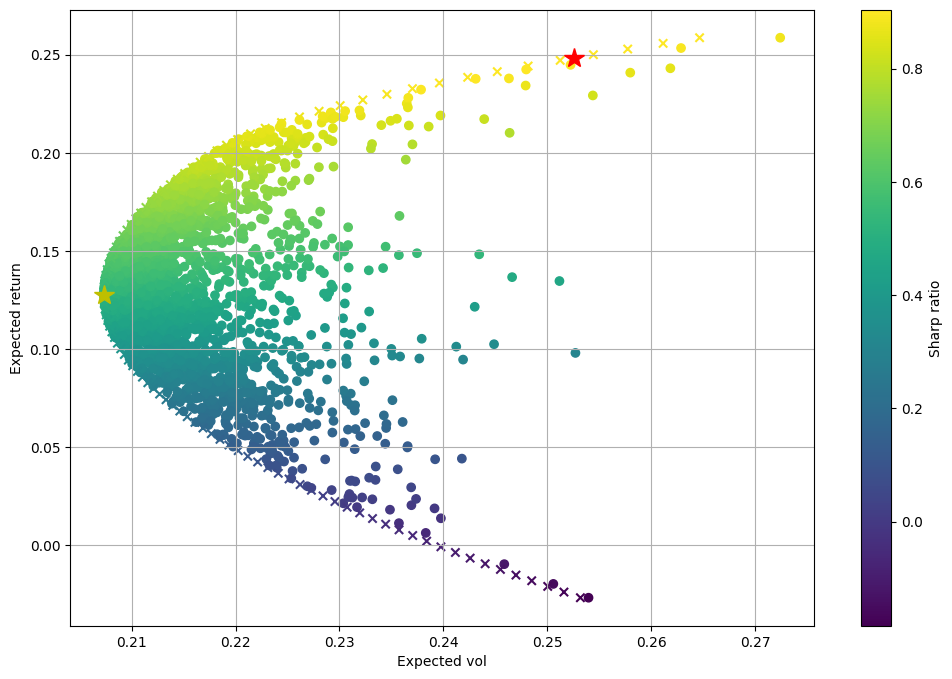

In [39]:
_ = plt.figure(figsize=(12, 8))
_ = plt.scatter(vols, rets, c=(rets - r_f) / vols, marker='o')
_ = plt.scatter(lvols, lrets, c=(lrets - r_f) / lvols, marker='x')
_ = plt.plot(port_vol(opts['x'], cov),
             port_mean(opts['x'], means),
             'r*',
             markersize=15)
_ = plt.plot(port_vol(optv['x'], cov),
             port_mean(optv['x'], means),
             'y*',
             markersize=15)
_ = plt.grid(True)
_ = plt.xlabel('Expected vol')
_ = plt.ylabel('Expected return')
_ = plt.colorbar(label='Sharp ratio')


## 5. Построение CML и нахождение касательного портфеля (опциональная часть задания)

In [40]:
# максмальное значение волатильности
max_vol = max(lvols)
# индекс значения с минимальной волатильностью в массиве волатильностей эффективной границы
ind = np.argmin(lvols)
ind

54

In [41]:
# часть эффективной границы выше минимальной волатильности
evols = lvols[ind:]
erets = lrets[ind:]


In [42]:
evols

array([0.20731528, 0.20734428, 0.20740787, 0.20750659, 0.20763974,
       0.20780811, 0.20801035, 0.20824725, 0.20851863, 0.20882574,
       0.20916431, 0.20953787, 0.20994626, 0.21038877, 0.21086069,
       0.21136829, 0.21190877, 0.21248184, 0.21308722, 0.21372464,
       0.21439383, 0.21509717, 0.21582959, 0.216592  , 0.21738499,
       0.21820823, 0.21912069, 0.22019608, 0.22144217, 0.22285231,
       0.2244234 , 0.22615211, 0.22803839, 0.23006995, 0.23224815,
       0.23456893, 0.23702808, 0.23962136, 0.24234445, 0.24519302,
       0.24816277, 0.25124938, 0.25444862, 0.25775005, 0.26116003,
       0.26467031])

In [43]:
erets

array([0.12898165, 0.13186294, 0.13474423, 0.13762552, 0.14050681,
       0.14338809, 0.14626938, 0.14915067, 0.15203196, 0.15491325,
       0.15779454, 0.16067583, 0.16355712, 0.16643841, 0.1693197 ,
       0.17220099, 0.17508227, 0.17796356, 0.18084485, 0.18372614,
       0.18660743, 0.18948872, 0.19237001, 0.1952513 , 0.19813259,
       0.20101388, 0.20389516, 0.20677645, 0.20965774, 0.21253903,
       0.21542032, 0.21830161, 0.2211829 , 0.22406419, 0.22694548,
       0.22982677, 0.23270806, 0.23558934, 0.23847063, 0.24135192,
       0.24423321, 0.2471145 , 0.24999579, 0.25287708, 0.25575837,
       0.25863966])

In [44]:
# интерполяция сплайнами (расчет узлов)
tck = sci.splrep(evols, erets)

# нахождение параметров касательной линии к эффективной границе
opt = sco.fsolve(equations, [0.02, 0.3, 0.15], (r_f, tck))

opt

array([0.02      , 0.90396975, 0.25245995])

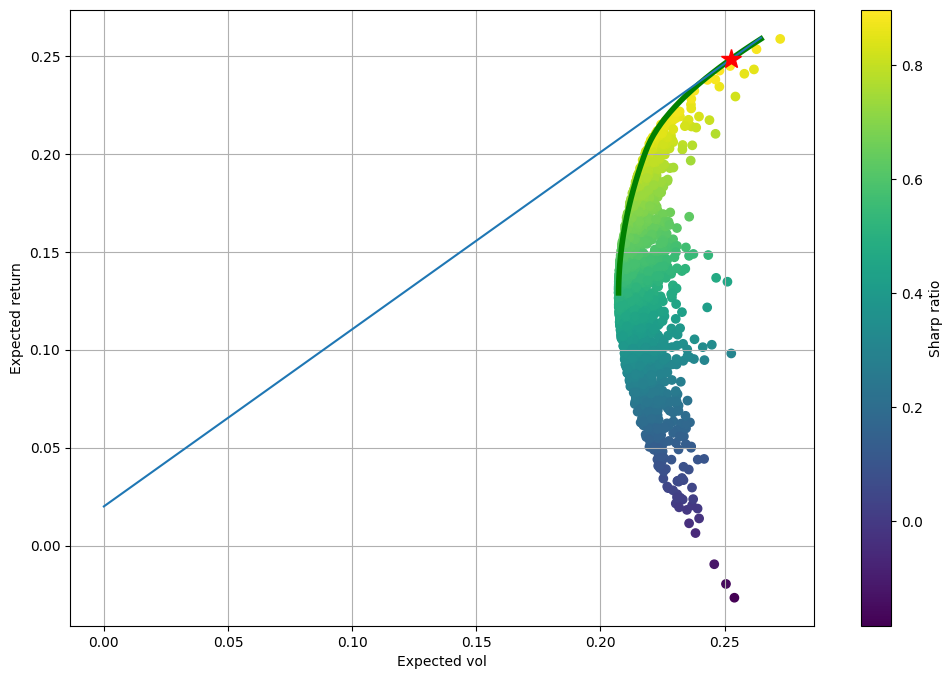

In [45]:
_ = plt.figure(figsize=(12, 8))
_ = plt.scatter(vols, rets, c=(rets - r_f) / vols, marker='o')
_ = plt.plot(evols, erets, 'g', lw=4.0)
cx = np.linspace(0, max_vol)
_ = plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
_ = plt.plot(opt[2], f(opt[2], tck), 'r*', markersize=15)
_ = plt.grid(True)
_ = plt.xlabel('Expected vol')
_ = plt.ylabel('Expected return')
_ = plt.colorbar(label='Sharp ratio')


In [46]:
cons=({'type':'eq','fun':lambda x:port_mean(x,means)-f(opt[2],tck)},\
    {'type':'eq','fun':lambda x:np.sum(x)-1})

In [47]:
# нахождение касательного портфеля
res = sco.minimize(port_vol,
                   w_initial, (cov),
                   method='SLSQP',
                   bounds=bnds,
                   constraints=cons)


In [48]:
# веса касательного портфеля
res['x'].round(3)

array([0.712, 0.   , 0.242, 0.046])

In [49]:
# доходность портфеля
f(opt[2], tck)


array(0.24821616)

# Выводы:

1. Выбрано четыре актива следующих компаний:
* AMZN -- Amazon.com, Inc.
* XOM -- Exxon Mobil Corporation
* V -- Visa Inc.
* JPM -- JPMorgan Chase & Co.
2. Для этих компаний построены различные варианты оптимальных портфелей и построена эффективная граница
3. Для выбранных активов построена Capital Market Line и найден касательный портфель